In [ ]:

import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse.linalg as spla
def plot_img(img, reshape_dim=None, cmap='gray'):
    if reshape_dim !=None:
        img = np.reshape(img, reshape_dim)
    plt.imshow(img, cmap='gray')
    plt.show()

def divide_dataset(X, Y, N_train):
    idxs = np.arange(0, len(X[0])-1, 1)
    np.random.shuffle(idxs)

    trian_idxs = idxs[:N_train]
    test_idxs = idxs[N_train:]


    XTrain = X[:,trian_idxs]
    YTrain = Y[trian_idxs]

    XTest = X[:,test_idxs]
    YTest = Y[test_idxs]

    return (XTrain, YTrain), (XTest, YTest)

def cluster_centroid(Z, Y, label):
    return np.mean(Z[:, Y==label], axis = 1 )

def PCA(X, k, reduced = True):

    centr = np.mean(X, axis = 1)
    XCentred = X - centr.reshape((len(centr), 1))

    U, s, VT = np.linalg.svd(XCentred, full_matrices=False)
    
    if reduced :
        reducedMatrix = 0
        for i in range(k):
            # single column matrix
            Vtemp = np.reshape(VT[i, :], (1, len(VT[0])))
            Utemp = np.reshape(U[:, i], (len(U[:, i]), 1))
            SingleMatrix =  Utemp @ Vtemp * s[i]
            reducedMatrix += SingleMatrix
    else:
        reducedMatrix = None
    Z = U[:,:k].T @ XCentred
    return  Z, reducedMatrix, U[:,:k]


def LDA(X, Y, classes, k):
    
    C_glob = X.mean(axis = 1)
    centroids = [X[:, (Y == value)].mean(axis = 1) for value in classes] 

    xlist = [X[:, (Y==values)] for values in classes]
    
    xcentredlist = []
    for i in range(len(xlist)):
        Xcc = xlist[i] - centroids[i].reshape(len(centroids[i]), 1)
        xcentredlist.append(Xcc)
    Xw = np.concatenate(xcentredlist, axis = 1)
    

    Sw = Xw @ Xw.T


    centr_matrix_list = []
    for i, centroid in enumerate(centroids):
        matrix = np.repeat(centroid.reshape(len(centroid), 1), len(xlist[i]), axis = 1)
        centr_matrix_list.append(matrix)
    C = np.concatenate(centr_matrix_list, axis = 1)
    Ccentred = C - C_glob.reshape(len(C_glob), 1)

    Sb = Ccentred @ Ccentred.T 
    
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        identity = epsilon * np.eye(Sw.shape[0])
        Sw += identity
        L = np.linalg.cholesky(Sw)
    
    P = np.linalg.inv(L) @ Sb @ L

    _, eigv = spla.eigs(P, k)

    Q = np.linalg.inv(L).T @ np.real(eigv)


    Z = Q.T @ X
    return Z, Q



def average_distance(Z, Y, label, centroid, norm=False):
    distances = [np.linalg.norm(Z[:, i] - centroid) for i in range(Z.shape[1]) if Y[i]==label]

    if norm:
        min_dist = np.min(distances)
        max_dist = np.max(distances)

        distances = [(di-min_dist)/(max_dist-min_dist) for di in distances]
    dist = np.mean(distances)
    
    return dist

def classification_algorithm(obs, centroids, labels, gt):
    dict_distances = { average_distance(obs.reshape(len(obs), 1), [1], 1, centroids[i]) : label for i, label in enumerate(labels)}
    
    idx_min = min(dict_distances.keys())

    predicted_class = dict_distances[idx_min]  
    
    return predicted_class == gt

def accuracy(X, centr, labels, Y):
    results = [classification_algorithm(X[:, i], centr, labels, gt) for i, gt in enumerate(Y)]

    correct_pred = np.sum(results)

    correctness = correct_pred / len(Y)
    return correctness

#### 1. Loading Data

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('data.csv')

print(data.head)

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

#### 2. Split labels and data points

In [ ]:
#Lets divide the labels array from the images
data = np.array(data).T

X = data[1:, :]
Y = data[0, :]

print('Dataset shape : {}\nLabels array shape : {}'.format(X.shape, Y.shape))

Dataset shape : (784, 42000)
Labels array shape : (42000,)


#### 3. Digits selection and reduction of dataset

In [ ]:
classes = (2, 3, 5) 

masks = [Y == i for i in classes]

Xlist = [X[:, mask] for mask in masks]

Ylist = [Y[mask] for mask in masks]

print('Single class datasets shape')
print([X.shape for X in Xlist])

X = np.concatenate(Xlist, axis=1) 
Y = np.concatenate(Ylist)

print('Reduced dataset dimension :\n')
print('X : {}\nY : {} '.format(X.shape, Y.shape))

Single class datasets shape
[(784, 4177), (784, 4351), (784, 3795)]
Reduced dataset dimension :

X : (784, 12323)
Y : (12323,) 


#### 4. Split into train and test

Train set shape : (784, 9858)
Test set shape : (784, 2464)
Image taken from test set labeled as : 3


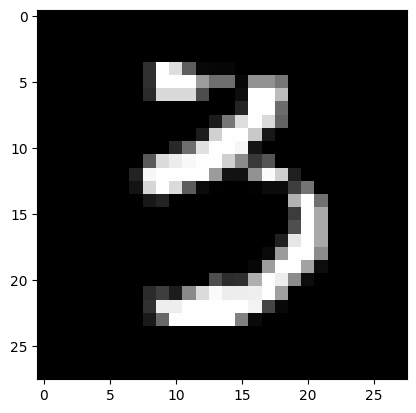

In [ ]:
Nsamples = int(0.8 * Y.shape[0])
(Xtrain, Ytrain), (Xtest, Ytest) = divide_dataset(X, Y, Nsamples)

print('Train set shape : {}'.format(Xtrain.shape))
print('Test set shape : {}'.format(Xtest.shape))

print("Image taken from test set labeled as : {}".format(Ytrain[0]))
plot_img(Xtrain[:, 0], (28, 28))

#### 5. PCA and LDA implementation

Values of the PCA centroids : [array([-643.98291529, -209.96853943]), array([ 393.10525998, -149.68699817]), array([256.27903713, 406.68144716])]
Values of the average distances from the centroid : [534.7932914639047, 525.3355953996659, 619.4728508690735]
Values od the LDA centroids : [array([ 0.03015606, -0.01172169]), array([-0.0091066 , -0.02583136]), array([-0.01718637,  0.01146378])]
Values of the average distances from the centroid : [0.012393543984316696, 0.011117876805724208, 0.013224668177653234]


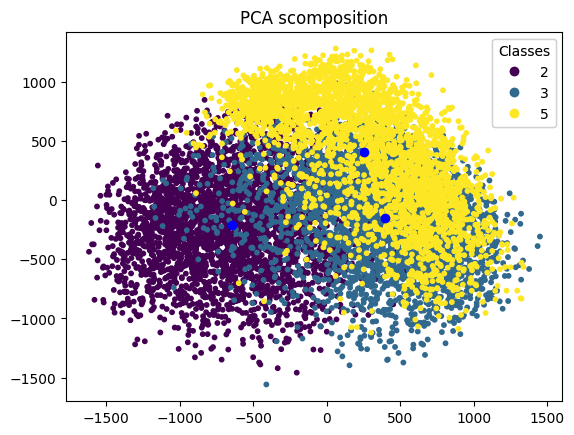

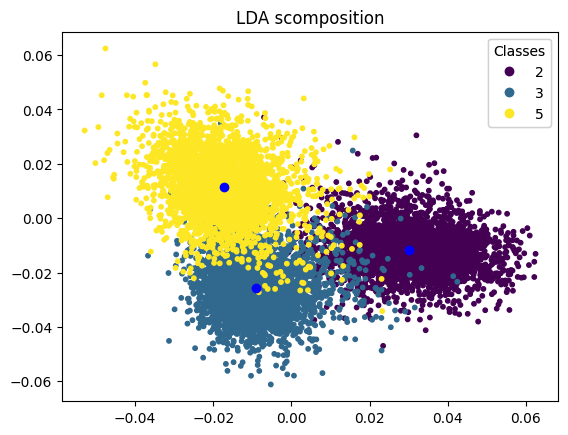

In [ ]:
#Reordering of the Train set
Xtrain = np.concatenate([Xtrain[:, Ytrain == digit] for digit in classes], axis = 1)
Ytrain = np.concatenate([Ytrain[Ytrain == digit] for digit in classes])


Z_pca, _, Projector_PCA = PCA(Xtrain, 2, classes)

centroids_pca = [cluster_centroid(Z_pca, Ytrain, label) for label in classes]
print('Values of the PCA centroids : {}'.format(centroids_pca))

avg_dist = [average_distance(Z_pca[:10], Ytrain, classes[i], centr, norm=True) for i, centr in enumerate(centroids_pca)]

print('Values of the average distances from the centroid : {}'. format(avg_dist))
Z_lda, Projector_LDA = LDA(Xtrain, Ytrain, classes, k = 2)

centroids_lda = [cluster_centroid(Z_lda, Ytrain, label) for label in classes]
avg_dist_lda = [average_distance(Z_lda, Ytrain, classes[i], centr, norm=True) for i, centr in enumerate(centroids_lda)]

print('Values od the LDA centroids : {}'.format(centroids_lda))
print('Values of the average distances from the centroid : {}'. format(avg_dist_lda))

# Plotting pca and lda clustering with centroids and distances
fig, ax = plt.subplots()
# Plot average distances in horizional starting from the centre
for i, centr in enumerate(centroids_pca):
    plt.plot(centr[0], centr[1], marker = 'o', c = 'b')
sc = plt.scatter(Z_pca[0, :], Z_pca[1, :], c=Ytrain, s=10)
leg = plt.legend(*sc.legend_elements(), title = 'Classes')
ax.add_artist(leg)
plt.title('PCA scomposition')
plt.show()

fig, ax = plt.subplots()
for i, centr in enumerate(centroids_lda):
    plt.plot(centr[0], centr[1], marker = 'o', c = 'b')
sc = plt.scatter(Z_lda[0, :], Z_lda[1, :], c=Ytrain, s=10)
leg = plt.legend(*sc.legend_elements(), title = 'Classes')
ax.add_artist(leg)
plt.title('LDA scomposition')
plt.show()

#### 6) PCA and LDA accuracy on test data

Values of the average distances from the centroid PCA : [537.2081684889699, 521.0353765750131, 609.6900762087026]
Values of the average distances from the centroid LDA : [0.013893774679890288, 0.011712364515260908, 0.014486436459110198]


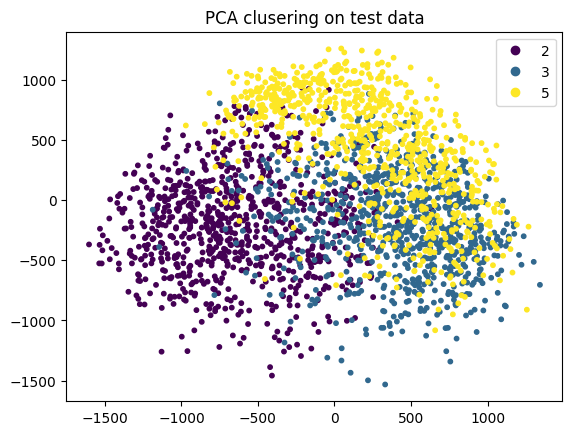

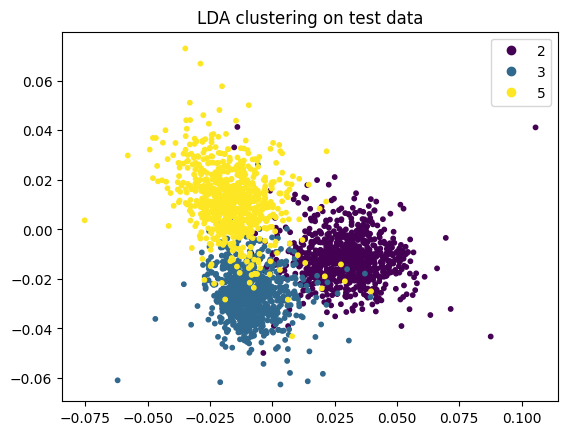

In [ ]:
Xtest = np.concatenate([Xtest[:, Ytest == digit] for digit in classes], axis = 1)
Ytest = np.concatenate([Ytest[Ytest == digit] for digit in classes])

Xtest_pca =  Projector_PCA.T @ (Xtest - np.reshape(np.mean(Xtest, axis = 1), (len(np.mean(Xtest, axis = 1)), 1)))

Xtest_lda = Projector_LDA.T @ Xtest

avg_dist_pca_test = [average_distance(Xtest_pca, Ytest, label, centroids_pca[i]) for i, label in enumerate(classes)] 
avg_dist_lda_test = [average_distance(Xtest_lda, Ytest, label, centroids_lda[i]) for i, label in enumerate(classes)]

print('Values of the average distances from the centroid PCA : {}'. format(avg_dist_pca_test))
print('Values of the average distances from the centroid LDA : {}'. format(avg_dist_lda_test))


sc = plt.scatter(Xtest_pca[0, :], Xtest_pca[1, :], c=Ytest, s=10)
plt.title("PCA clusering on test data")
plt.legend(*sc.legend_elements())
plt.show()
sc = plt.scatter(Xtest_lda[0, :], Xtest_lda[1, :], c=Ytest, s=10)
plt.legend(*sc.legend_elements())
plt.title("LDA clustering on test data")
plt.show()

#### 7) Classification task results

In [ ]:
accuracy_pca = accuracy(Xtest_pca, centroids_pca, classes, Ytest)
print('PCA accuracy on test set : {}'.format(accuracy_pca))


accuracy_lda = accuracy(Xtest_lda, centroids_lda, classes, Ytest) 
print('LDA accuracy on test set : {}'.format(accuracy_lda))

PCA accuracy on test set : 0.7337662337662337
LDA accuracy on test set : 0.9314123376623377


#### 8) Classification accuracy when k grows

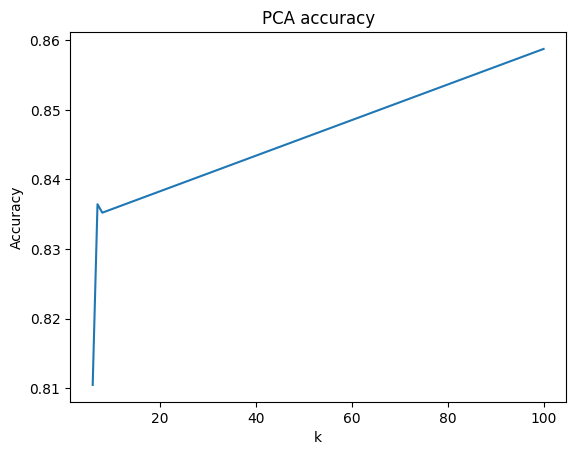

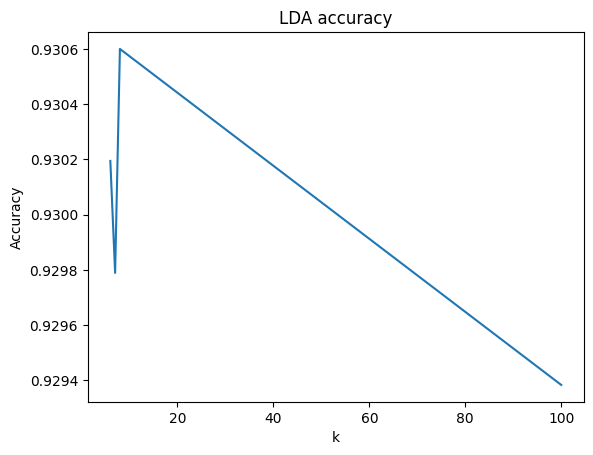

In [ ]:
k_list = [6, 7, 8, 100]
accuracy_pca = []
accuracy_lda = []
for k in k_list:
    Z_pca, _, Projector_PCA = PCA(Xtrain, k, classes)
    Z_lda, Projector_LDA = LDA(Xtrain, Ytrain, classes, k)

    centroids_pca = [cluster_centroid(Z_pca, Ytrain, label) for label in classes]
    centroids_lda = [cluster_centroid(Z_lda, Ytrain, label) for label in classes]

    Xtest_pca =  Projector_PCA.T @ (Xtest - np.reshape(np.mean(Xtest, axis = 1), (len(np.mean(Xtest, axis = 1)), 1)))

    Xtest_lda = Projector_LDA.T @ Xtest

    accuracy_pca.append(accuracy(Xtest_pca, centroids_pca, classes, Ytest))
    accuracy_lda.append(accuracy(Xtest_lda, centroids_lda, classes, Ytest)) 
plt.plot(k_list, accuracy_pca)
plt.title("PCA accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()
plt.title("LDA accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(k_list, accuracy_lda)
plt.show()

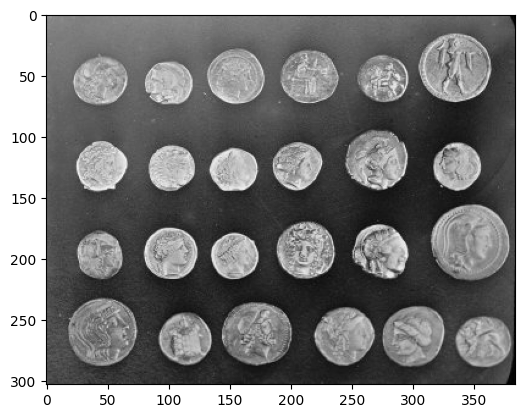

In [ ]:
import skimage.data as skd
img = skd.coins()
plt.imshow(img, cmap = 'gray')
plt.show()

#### 9) SVD of the image

In [ ]:
U, s , VT = np.linalg.svd(img, full_matrices=True)

print(U.shape, VT.shape)
print(U[:, 0].shape, VT[0, :].shape )

(303, 303) (384, 384)
(303,) (384,)


#### 10) Dyads visualization

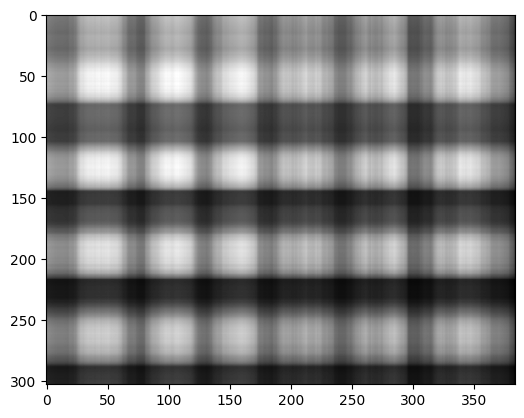

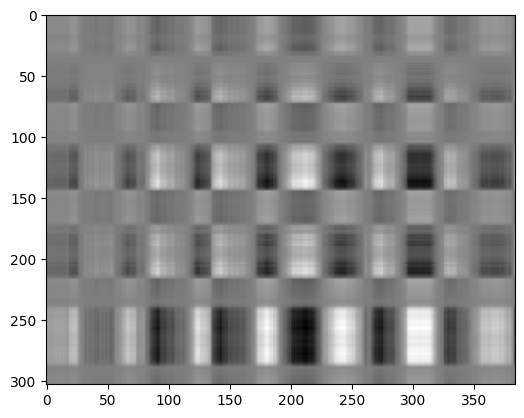

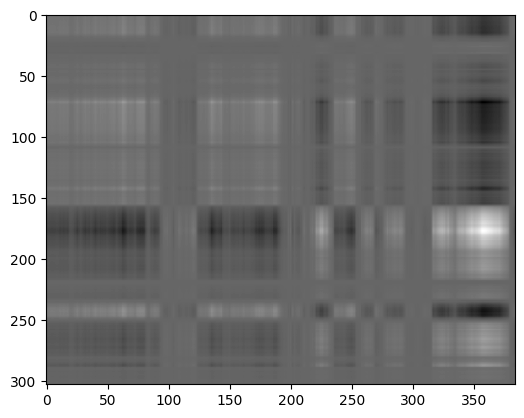

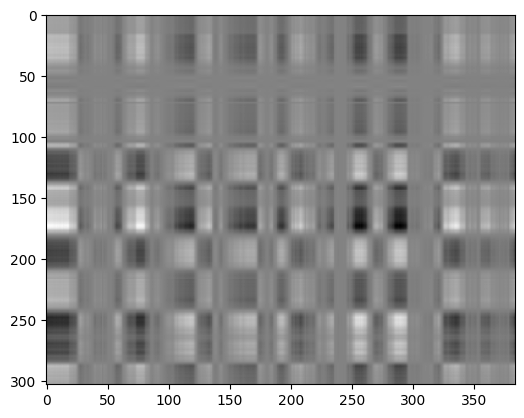

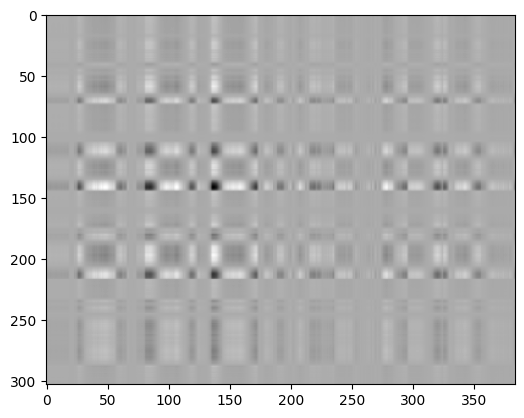

In [ ]:
for i in range(5):
    Ui = U[:, i].reshape(len(U[0]), 1)
    VTi = VT[i, :].reshape(1, len(VT[0]))
    dyad = Ui @ VTi * s[i]
    plt.imshow(dyad, cmap='gray')
    plt.show()

#### 11) Singluar values

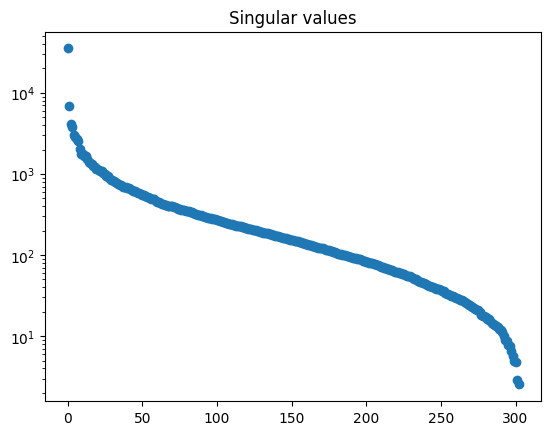

In [ ]:
plt.plot(range(len(s)),s, 'o')
plt.title('Singular values')
plt.yscale('log')
plt.show()

#### 12) k-dimensional reduction

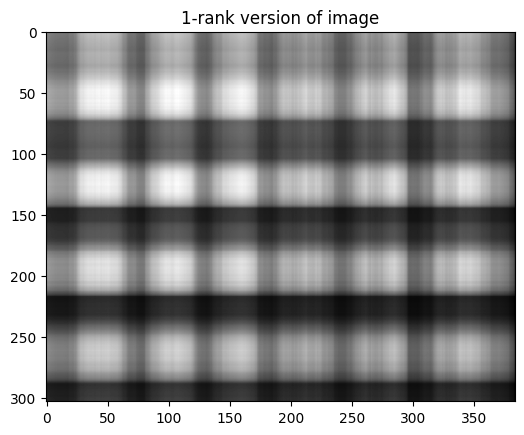

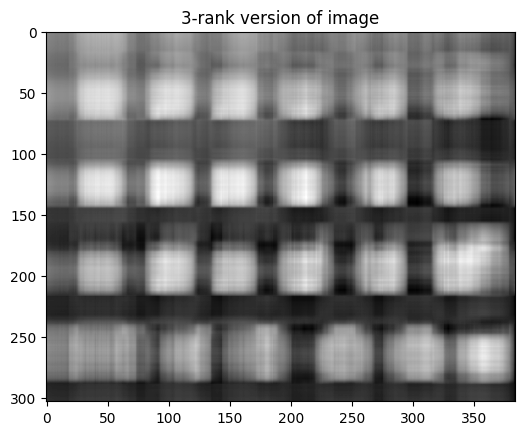

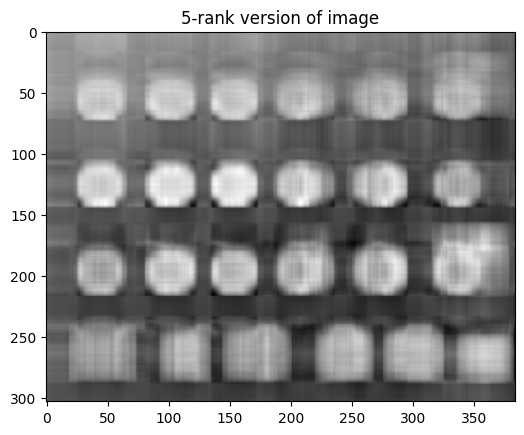

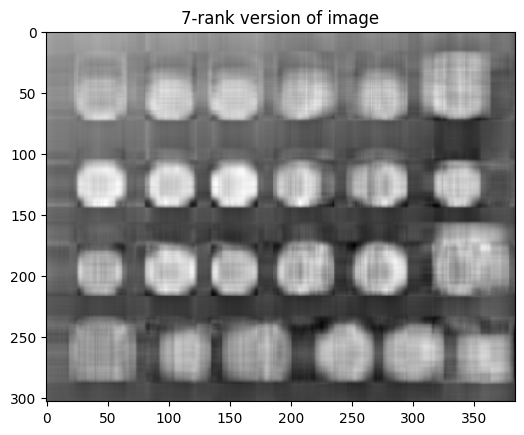

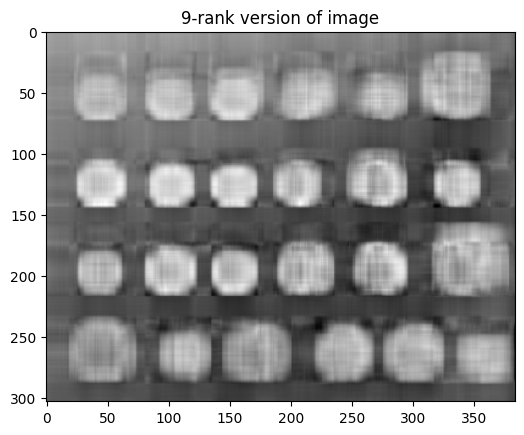

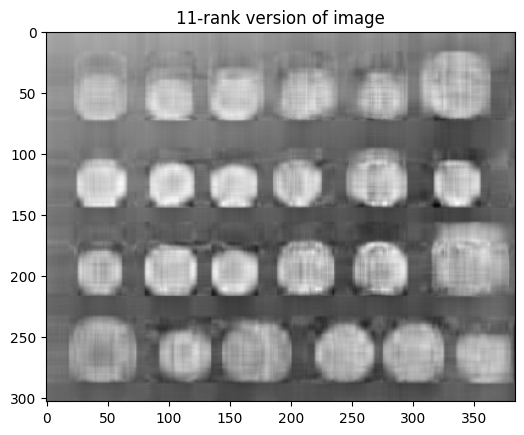

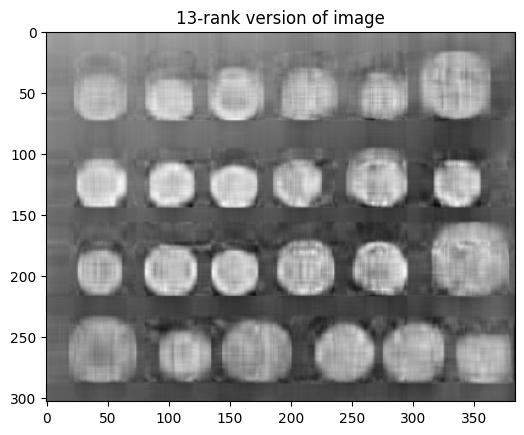

In [ ]:
for k in range(1, 15, 2):
    sum = np.zeros(img.shape)
    for i in range(k): 
        Ui = U[:, i].reshape(len(U[0]), 1)
        VTi = VT[i, :].reshape(1, len(VT[0])) 
        sum += Ui @ VTi * s[i]
    plt.imshow(sum, cmap='gray')
    plt.title('{}-rank version of image'.format(k))
    plt.show()

# Relative error

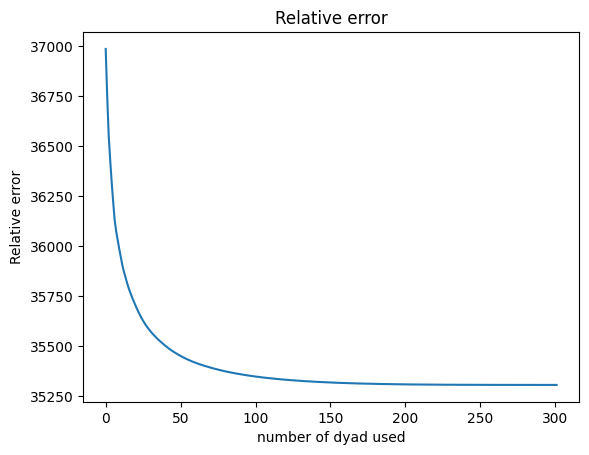

In [ ]:
sum = np.zeros(img.shape)
errors = []
for i in range(1, len(s)):
    Ui = U[:, i].reshape(len(U[0]), 1)
    VTi = VT[i, :].reshape(1, len(VT[0])) 
    dyad = Ui @ VTi * s[i]
    sum += dyad
    rel_error = np.linalg.norm((img - sum))
    errors.append(rel_error)
plt.plot(range(len(errors)), errors)
plt.title("Relative error")
plt.xlabel('number of dyad used')
plt.ylabel('Relative error')
plt.show()

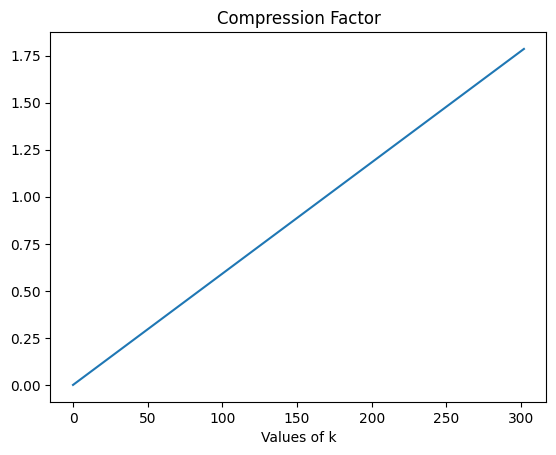

In [ ]:
comp_factor_list = [k * (1 + img.shape[0] + img.shape[1]) / (img.shape[0] * img.shape[1]) for k in range(len(s))]
plt.plot(range(len(s)), comp_factor_list)
plt.title('Compression Factor')
plt.xlabel('Values of k')
plt.show()

In [ ]:
# Comparison
import numpy as np
import pandas as pd

data = pd.read_csv('data.csv')

#Lets divide the labels array from the images
data = np.array(data).T

X = data[1:, :]
Y = data[0, :]


In [ ]:
newk = 2
cl = (7, 8) 

msks = [Y == i for i in cl]

Xl = [X[:, m] for m in msks]

Yl = [Y[m] for m in msks]


X = np.concatenate(Xl, axis=1) 
Y = np.concatenate(Yl)

Ns = int(0.8 * Y.shape[0])

(Xtr, Ytr), (Xte, Yte) = divide_dataset(X, Y, Ns)


#Reordering of the Train set
Xtr = np.concatenate([Xtr[:, Ytr == digit] for digit in cl], axis = 1)
Ytr = np.concatenate([Ytr[Ytr == digit] for digit in cl])
print(Xtrain.shape)

Zpca, _, Pr_PCA = PCA(Xtr, newk, cl)

ct_pca = [cluster_centroid(Zpca, Ytr, label) for label in cl]


Zlda, Pr_LDA = LDA(Xtr, Ytr, cl, k = 2)
ct_lda = [cluster_centroid(Zlda, Ytr, label) for label in cl]

Xtest = np.concatenate([Xte[:, Yte == digit] for digit in cl], axis = 1)
Ytest = np.concatenate([Yte[Yte == digit] for digit in cl])

Xtpca =  Pr_PCA.T @ (Xte - np.reshape(np.mean(Xte, axis = 1), (len(np.mean(Xte, axis = 1)), 1)))

Xtlda = Pr_LDA.T @ Xte


acc_pca = accuracy(Xtpca, ct_pca, cl, Yte)
print('PCA accuracy on test set : {}'.format(acc_pca))


acc_lda = accuracy(Xtlda, ct_lda, cl, Yte) 
print('LDA accuracy on test set : {}'.format(acc_lda))

(784, 9858)
PCA accuracy on test set : 0.9621749408983451
LDA accuracy on test set : 0.9816784869976359
